In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import cv2

In [2]:
class Node:
    def __init__(self):
        self.rank = 0
        self.size = (0, 0)
        self.singular_values = []
        self.U = None
        self.V = None
        self.children = []
        self.channels = []

    def __repr__(self):
        return f"Node(rank={self.rank}, size={self.size},\
            children={len(self.children)})"

In [3]:
def truncated_SVD(A, rank):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    return U[:, :rank], np.diag(S[:rank]), Vt[:rank, :]

In [4]:
def compress_matrix(A, tmin, tmax, smin, smax, U, D, V, r):
    node = Node()
    if np.all(A[tmin:tmax, smin:smax] == 0):
        node.rank = 0
        node.size = (tmax - tmin, smax - smin)
        return node
    
    sigma = np.diag(D)
    node.rank = r
    node.size = (tmax - tmin, smax - smin)
    node.singular_values = sigma[:r].tolist()
    node.U = U[:, :r].tolist()
    node.V = (D[:r, :r] @ V[:r, :]).tolist()
    return node

In [5]:
def create_tree(A, tmin, tmax, smin, smax, r, epsilon):
    if tmax - tmin <= 1 and smax - smin <= 1:
        node = Node()
        node.rank = 1
        node.size = (1, 1)
        node.singular_values = [A[tmin, smin]]
        return node

    U, D, V = truncated_SVD(A[tmin:tmax, smin:smax], r + 1)

    if (D.shape[0] > r and D[r, r] < epsilon):
        new_r = sum(np.diag(D)[:r] > epsilon)
        return compress_matrix(A, tmin, tmax, smin, smax, U, D, V, new_r)
    
    node = Node()
    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2

    node.children.append(create_tree(A, tmin, tmid, smin, smid, r, epsilon))
    node.children.append(create_tree(A, tmin, tmid, smid, smax, r, epsilon))
    node.children.append(create_tree(A, tmid, tmax, smin, smid, r, epsilon))
    node.children.append(create_tree(A, tmid, tmax, smid, smax, r, epsilon))
    return node

In [6]:
def reconstruct_matrix(node, tmin, tmax, smin, smax, matrix):
    if not node.children:
        if node.rank == 0:
            matrix[tmin:tmax, smin:smax] = 0
        elif node.rank == 1 and node.size == (1, 1):
            matrix[tmin, smin] = node.singular_values[0]
        else:
            U = np.array(node.U)
            V = np.array(node.V)
            reconstructed_block = U @ V
            
            matrix[tmin:tmax, smin:smax] += reconstructed_block
        return
    
    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2

    reconstruct_matrix(node.children[0], tmin, tmid, smin, smid, matrix)
    reconstruct_matrix(node.children[1], tmin, tmid, smid, smax, matrix)
    reconstruct_matrix(node.children[2], tmid, tmax, smin, smid, matrix)
    reconstruct_matrix(node.children[3], tmid, tmax, smid, smax, matrix)

def reconstruct_from_tree(root, matrix_size):
    reconstructed_matrix = np.zeros(matrix_size[:2])
    reconstruct_matrix(root, 0, matrix_size[0], 0, matrix_size[1], reconstructed_matrix)
    return reconstructed_matrix

In [7]:
INT_SIZE = 4
FLOAT_SIZE = 4

def calculate_compressed_memory(node):
    memory = 0

    if len(node.channels) > 0:
        for channel in node.channels:
            memory += 8 # channel pointer
            memory += calculate_compressed_memory(channel)
        return memory

    if not node.children:
        memory += INT_SIZE # rank (int)
        memory += 2 * INT_SIZE # size (int, int)

        if node.rank > 0:
            block_height, block_width = node.size
            r = node.rank

            memory += r * FLOAT_SIZE # singular values
            memory += block_height * r * FLOAT_SIZE # U matrix
            memory += r * block_width * FLOAT_SIZE # V matrix

        return memory

    for child in node.children:
        memory += 8 # child pointer
        memory += calculate_compressed_memory(child)
    return memory

def compare_memory_usage(original_matrix, compressed_matrix):
    original_memory = original_matrix.size * original_matrix.itemsize
    compressed_memory = calculate_compressed_memory(compressed_matrix)

    print(f"Original Space: {original_memory} B")
    print(f"Compressed Space: {compressed_memory} B")
    print(f"Compression Ratio: {compressed_memory / original_memory:.2f}")

In [8]:
def draw_compressed_matrix(node, tmin, tmax, smin, smax, ax):
    if not node.children:
        rect = patches.Rectangle((smin, tmin), smax - smin, tmax - tmin, 
                                 linewidth=0.9, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        return

    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2

    draw_compressed_matrix(node.children[0], tmin, tmid, smin, smid, ax)
    draw_compressed_matrix(node.children[1], tmin, tmid, smid, smax, ax)
    draw_compressed_matrix(node.children[2], tmid, tmax, smin, smid, ax)
    draw_compressed_matrix(node.children[3], tmid, tmax, smid, smax, ax)

def visualize_compressed_matrix(matrix, root):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(matrix, cmap='gray', vmin=0, vmax=255, alpha=0.7)
    draw_compressed_matrix(root, 0, matrix.shape[0], 0, matrix.shape[1], ax)
    plt.title("Compressed Matrix Visualization")
    plt.axis('off')
    plt.show()

In [9]:
def compress_colour_image(I, tmin, tmax, smin, smax, r, epsilon):
    R, G, B = cv2.split(I)

    R_compressed = create_tree(R, tmin, tmax, smin, smax, r, epsilon)
    G_compressed = create_tree(G, tmin, tmax, smin, smax, r, epsilon)
    B_compressed = create_tree(B, tmin, tmax, smin, smax, r, epsilon)

    node = Node()
    node.channels.extend([R_compressed, G_compressed, B_compressed])
    return node

def reconstruct_colour_image(root, size):
    R = reconstruct_from_tree(root.channels[0], size)
    G = reconstruct_from_tree(root.channels[1], size)
    B = reconstruct_from_tree(root.channels[2], size)

    R = np.clip(R, 0, 255)
    G = np.clip(G, 0, 255)
    B = np.clip(B, 0, 255)

    I = cv2.merge((R, G, B)).astype(np.uint8)
    return I

def visualize_compressed_colour_image(I_org, I_comp):
    I_decomp = reconstruct_colour_image(I_comp, I_org.shape)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.delaxes(axs[0, 2])

    axs[0,0].imshow(I_org, vmin=0, vmax=255)
    axs[0,1].imshow(I_decomp, vmin=0, vmax=255)

    axs[1,0].imshow(I_org[:, :, 0], cmap='Reds',  vmin=0, vmax=255, alpha=0.6)
    draw_compressed_matrix(I_comp.channels[0], 0, I_org.shape[0], 0, I_org.shape[1], axs[1,0])
    axs[1,1].imshow(I_org[:, :, 1], cmap='Greens', vmin=0, vmax=255, alpha=0.6)
    draw_compressed_matrix(I_comp.channels[1], 0, I_org.shape[0], 0, I_org.shape[1], axs[1,1])
    axs[1,2].imshow(I_org[:, :, 2], cmap="Blues", vmin=0, vmax=255, alpha=0.6)
    draw_compressed_matrix(I_comp.channels[2], 0, I_org.shape[0], 0, I_org.shape[1], axs[1,2])

    for ax in axs.flat:
        ax.axis('off')

    plt.show()      

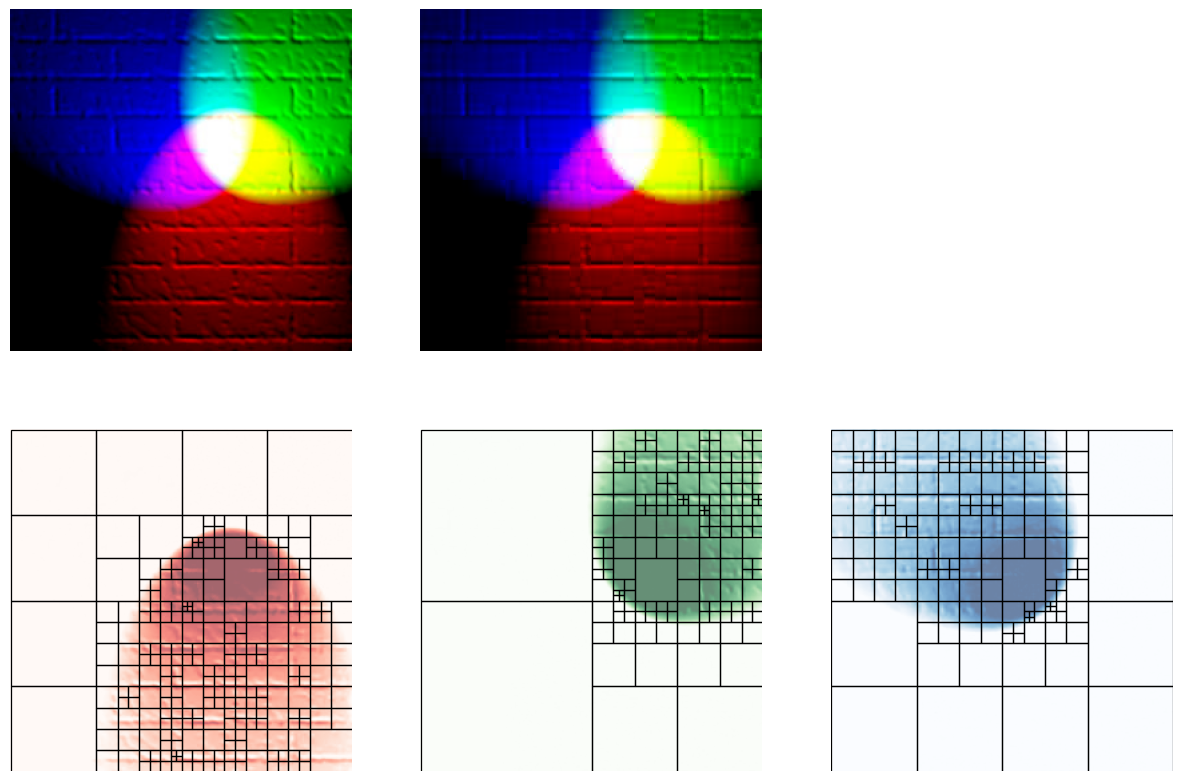

Original Space: 196608 B
Compressed Space: 67064 B
Compression Ratio: 0.34


In [10]:
Img = cv2.imread('rgb3.bmp')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
# print(Img.__sizeof__())

tmin, tmax = 0, Img.shape[0]
smin, smax = 0, Img.shape[1]
r = 1
epsilon = 150

I_comp = compress_colour_image(Img, tmin, tmax, smin, smax, r, epsilon)

visualize_compressed_colour_image(Img, I_comp)

compare_memory_usage(Img, I_comp)

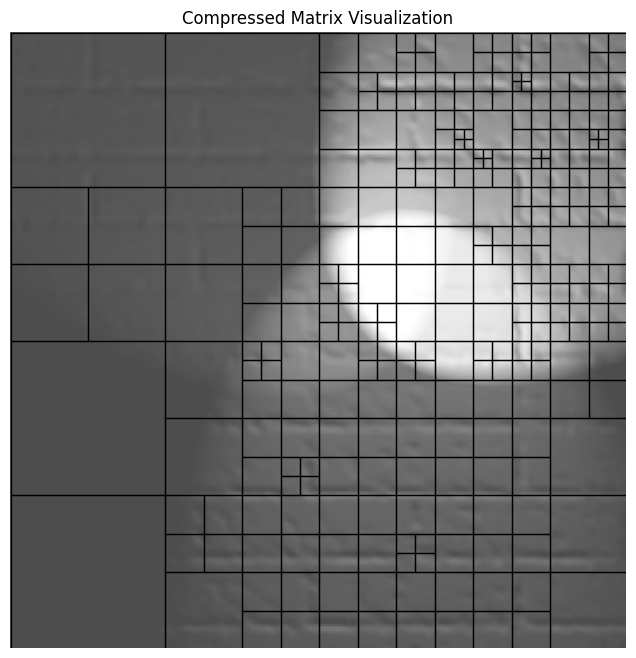

In [11]:
matrix = cv2.imread('rgb3.bmp', cv2.IMREAD_GRAYSCALE)

tmin, tmax = 0, matrix.shape[0]
smin, smax = 0, matrix.shape[1]
r = 2 
epsilon = 50 

root = create_tree(matrix, tmin, tmax, smin, smax, r, epsilon)

reconstructed_matrix = reconstruct_from_tree(root, matrix.shape)
visualize_compressed_matrix(matrix, root)

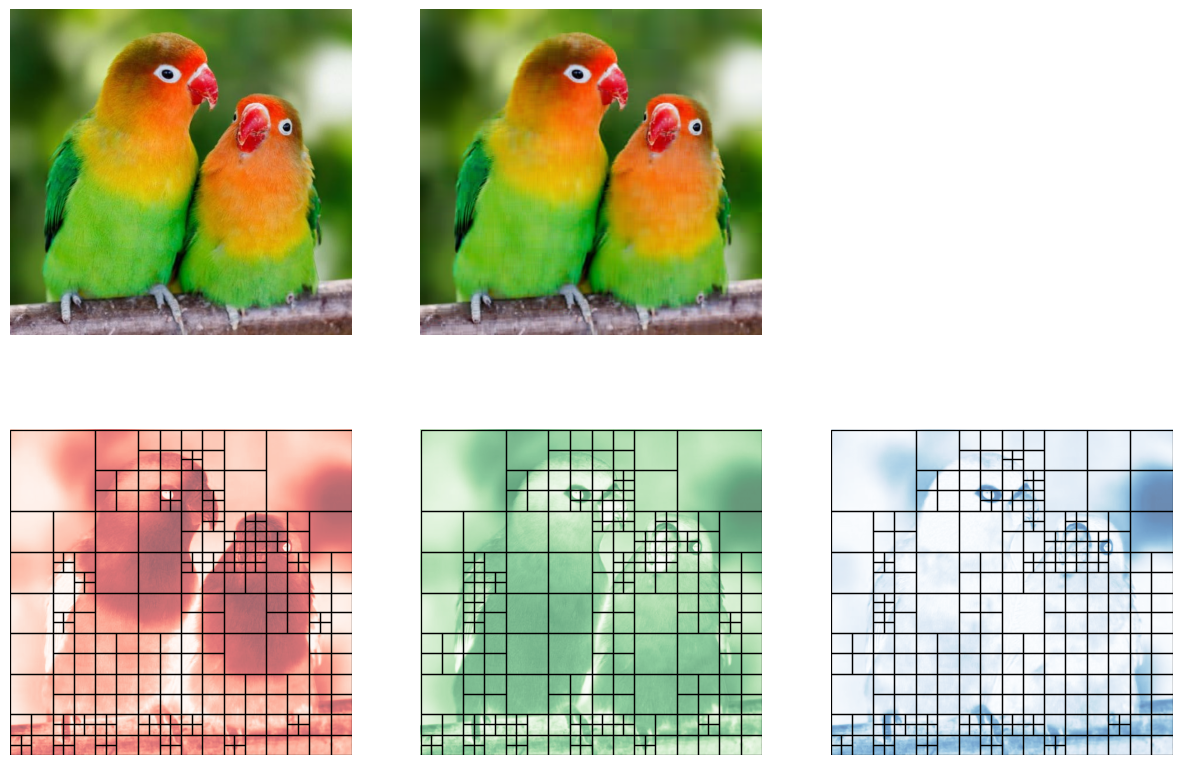

Original Space: 980964 B
Compressed Space: 620756 B
Compression Ratio: 0.63


In [14]:
Img = cv2.imread('bird2.1.jpg')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

tmin, tmax = 0, Img.shape[0]
smin, smax = 0, Img.shape[1]
r = 5
epsilon = 100

I_comp = compress_colour_image(Img, tmin, tmax, smin, smax, r, epsilon)

visualize_compressed_colour_image(Img, I_comp)

compare_memory_usage(Img, I_comp)

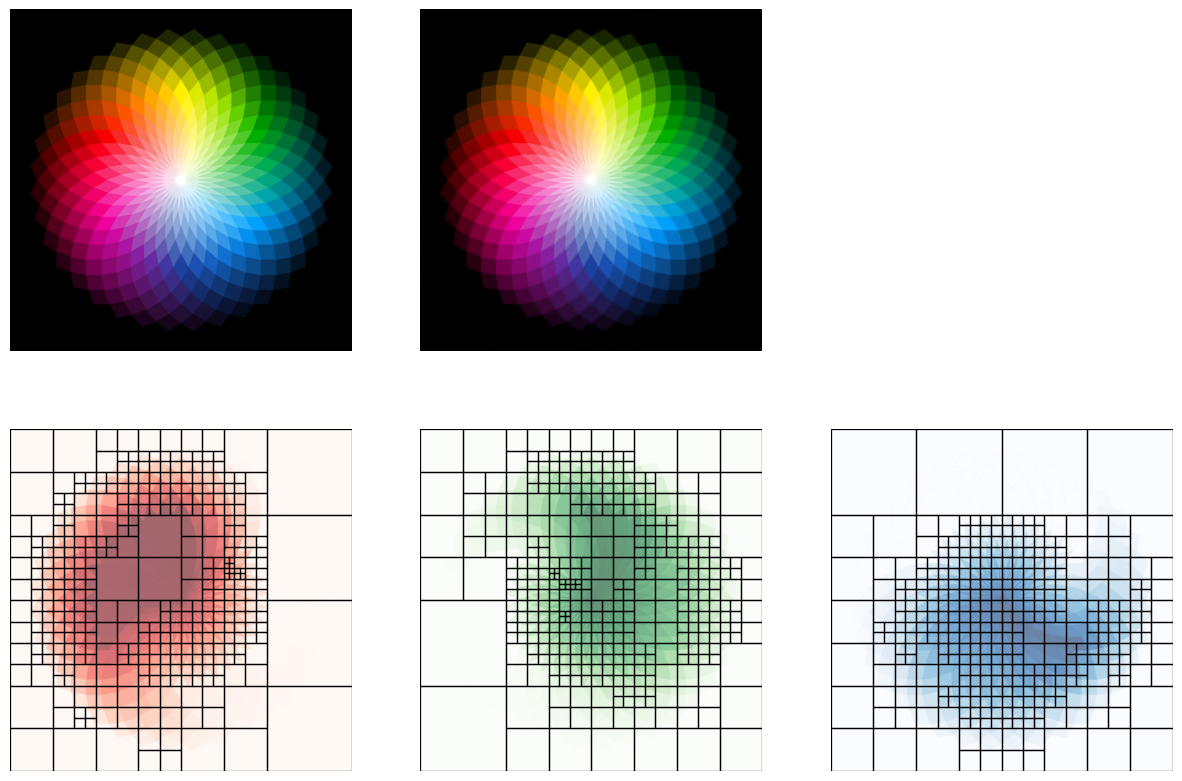

Original Space: 7680000 B
Compressed Space: 1773656 B
Compression Ratio: 0.23


In [13]:
Img = cv2.imread('colors.jpg')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

tmin, tmax = 0, Img.shape[0]
smin, smax = 0, Img.shape[1]
r = 5
epsilon = 150

I_comp = compress_colour_image(Img, tmin, tmax, smin, smax, r, epsilon)

visualize_compressed_colour_image(Img, I_comp)

compare_memory_usage(Img, I_comp)